# Experimental Evaluation for FMplex Variable Elimination

I want to inspect the following data:

- data sets: Random, SMT-Lib, NN-Verification
- solvers: FMplex, CDD, Redlog, FM
- timeout: 5 minutes
- memout: 4GB
- exact arithmetic

## 0. Imports and Utilities

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


solvers = ["FMplex", "CDD", "Redlog", "FM"]


def summary(df):
    answers = ['timeout','memout','segfault','abort','invalid','success']
    data = (
        [tuple([len(df[~df[(solver,'answer')].isnull()]) for solver in solvers])] # total
      + [
          tuple(df[(solver,'answer')].value_counts().get(answer,default=0) for solver in solvers)
          for answer in answers
        ]      
    )
    return pd.DataFrame(data,index = ['count'] + answers, columns=solvers)


def filter_rows(df, pred):
    return df[df.apply(pred, axis=1)]


def scatter_plot(df, solver1, solver2, field, **kwargs):
    ax = plt.gca()
    df.plot.scatter(ax = ax, x=(solver1, field), y=(solver2, field), **kwargs)
    ax.set_xlabel(solver1)
    ax.set_ylabel(solver2)
    return ax


def scatter_equal_line(ax):
    lower = max(ax.get_xlim()[0],ax.get_ylim()[0])
    upper = min(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot([lower, upper], [lower, upper], ls="--", c=".3")


def scatter_overview(df, column, **kwargs):
    other_solvers = [s for s in solvers if s != "FMplex"]
    total = len(other_solvers)

    plt.figure(figsize=(total * 4 + (total - 1) * 2, 4))
    for i in range(total):
        plt.subplot(1, total, i+1)
        ax = scatter_plot(df, "FMplex", other_solvers[i], column, **kwargs)
        ax.set_xscale("log")
        ax.set_yscale("log")
        scatter_equal_line(ax)
    plt.show()

## 1. Random Benchmarks

In [2]:
df_random = pd.read_csv("stats_random_all.csv", header=[0,1], index_col=0)
summary(df_random)

,FMplex,CDD,Redlog,FM
count,10000,10000,10000,10000
timeout,2518,2653,3288,0
memout,0,0,0,5368
segfault,0,0,0,0
abort,0,0,0,0
invalid,0,0,0,0
success,7482,7347,6712,4632


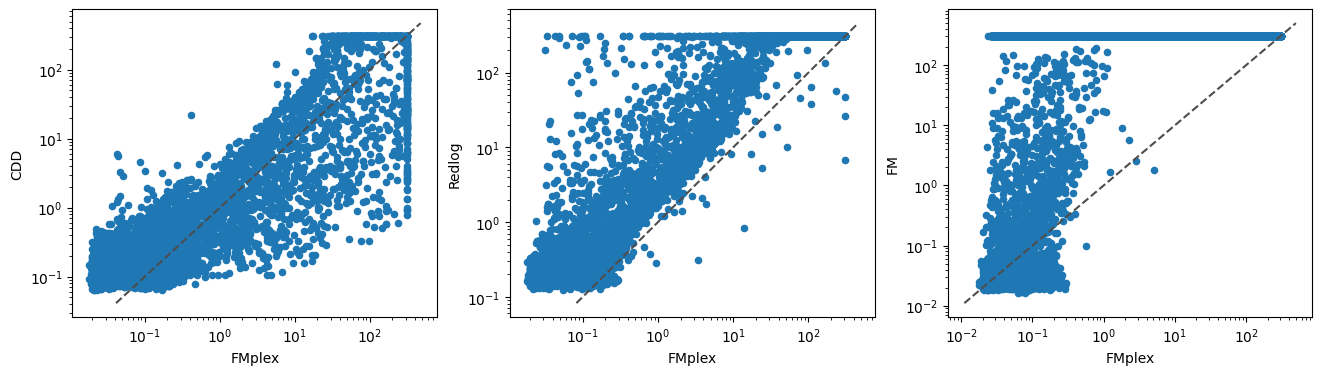

In [3]:
scatter_overview(df_random, "runtime")

/tmp/ipykernel_36505/1329430.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


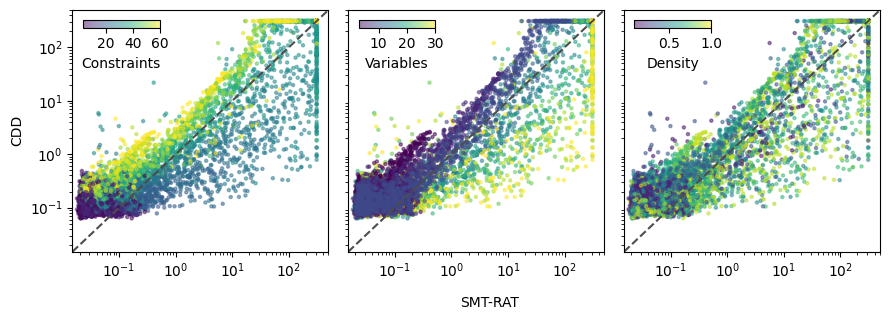

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colorings = [("stats", "constraints"), ("stats", "variables"), ("stats", "matrix-density-overall")]
stat_names = ["Constraints", "Variables", "Density"]
stat_ticks = [[0.,20,40,60],[0.,10,20,30],[0.,0.5,1]]

fig = plt.figure(figsize=(9, 3))
for i, stat in enumerate(colorings):
    plt.subplot(1, len(colorings), i + 1)
    sc = plt.scatter(
        x=df_random[("FMplex", "runtime")],
        y=df_random[("CDD", "runtime")],
        c=df_random[stat],
        cmap="viridis",
        alpha=0.5,
        s=5
    )
    ax = plt.gca()
    ax.set_xlim(0.015,500)
    ax.set_ylim(0.015,500)
    scatter_equal_line(ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    if i > 0:
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        plt.yticks([])
    else:
        ax.set_ylabel("CDD")
    
    cbaxes = inset_axes(ax, width="30%", height="3%", loc=2, borderpad=0.75) 
    cbar = fig.colorbar(sc, cax = cbaxes, orientation="horizontal", ticks = stat_ticks[i])
    cbar.ax.set_xlabel(stat_names[i])

fig.text(0.55, -0.04, 'SMT-RAT', ha='center')
fig.tight_layout()
plt.show()

In [5]:
solved_by_fm = df_random[df_random[("FM", "answer")] == "success"]
solved_by_cdd = df_random[df_random[("CDD", "answer")] == "success"]
solved_by_redlog = df_random[df_random[("Redlog", "answer")] == "success"]
solved_by_fmplex = df_random[df_random[("FMplex", "answer")] == "success"]

In [6]:
fm_faster = filter_rows(solved_by_fm, (lambda x: x[("FM","runtime")] < x[("FMplex","runtime")]))
fm_slower = filter_rows(solved_by_fmplex, (lambda x: x[("FM","runtime")] > x[("FMplex","runtime")]))
print("FM faster: " + str(len(fm_faster)))
print("FM faster and FMplex needs more than 0.5s: "
      + str(len(fm_faster[fm_faster[("FMplex", "runtime")] > 0.5])))
print("FM faster and FMplex needs more than 6s: "
      + str(len(fm_faster[fm_faster[("FMplex", "runtime")] > 6])))
print("FM slower: " + str(len(fm_slower)))

FM faster: 2648
FM faster and FMplex needs more than 0.5s: 3
FM faster and FMplex needs more than 6s: 0
FM slower: 4657


In [7]:
vs_faster = filter_rows(solved_by_redlog, (lambda x: x[("Redlog","runtime")] < x[("FMplex","runtime")]))
vs_slower = filter_rows(solved_by_fmplex, (lambda x: x[("Redlog","runtime")] > x[("FMplex","runtime")]))
print("Redlog faster: " + str(len(vs_faster)))
print("Redlog faster and FMplex needs more than 0.5s: "
      + str(len(vs_faster[vs_faster[("FMplex", "runtime")] > 0.5])))
print("Redlog faster and FMplex needs more than 10s: "
      + str(len(vs_faster[vs_faster[("FMplex", "runtime")] > 10])))
print("Redlog slower: " + str(len(vs_slower)))

Redlog faster: 154
Redlog faster and FMplex needs more than 0.5s: 26
Redlog faster and FMplex needs more than 10s: 14
Redlog slower: 7329


In [8]:
cdd_faster = filter_rows(solved_by_cdd, (lambda x: x[("CDD","runtime")] < x[("FMplex","runtime")]))
cdd_slower = filter_rows(solved_by_fmplex, (lambda x: x[("CDD","runtime")] > x[("FMplex","runtime")]))
print("CDD faster: " + str(len(cdd_faster)))
print("CDD faster and FMplex needs more than 0.5s: "
      + str(len(cdd_faster[cdd_faster[("FMplex", "runtime")] > 0.5])))
print("CDD faster and FMplex times out: "
      + str(len(cdd_faster[cdd_faster[("FMplex", "answer")] =="timeout"])))
print("CDD slower: " + str(len(cdd_slower)))
print("CDD slower and it needs more than 1s: " + str(len(cdd_slower[cdd_slower[("CDD", "runtime")] > 1])))

CDD faster: 1657
CDD faster and FMplex needs more than 0.5s: 1028
CDD faster and FMplex times out: 148
CDD slower: 5960
CDD slower and it needs more than 1s: 1060


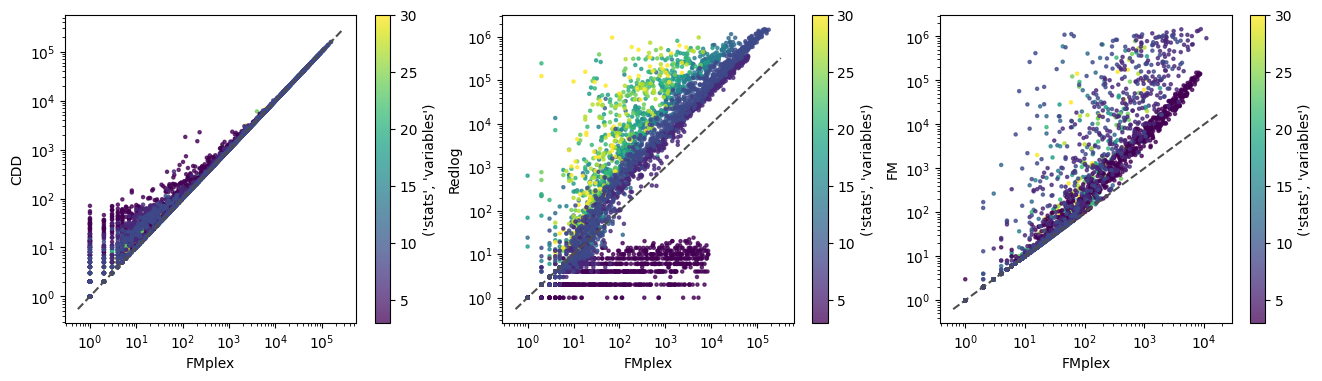

In [9]:
scatter_overview(df_random, "output_constraints",
                 c=("stats", "variables"),
                 colormap="viridis",
                 alpha=0.75, s=5
                )
plt.show()

In [10]:
def fewer_constraints(s1, s2):
    return (lambda x: x[(s1,"answer")] == "success" and x[(s2,"answer")] == "success" and x[(s1,"output_constraints")] < x[(s2, "output_constraints")])

print(len(filter_rows(df_random, fewer_constraints("CDD","FMplex"))))
print(len(filter_rows(df_random, fewer_constraints("FM","FMplex"))))
print(len(filter_rows(df_random, fewer_constraints("Redlog","FMplex"))))
print(len(filter_rows(df_random, fewer_constraints("FMplex","Redlog"))))


0
0
1241
2772


In [11]:
len(df_random[df_random[("Redlog","contains_disjunction")] == 1])

3352

## 2. Neural Network Verification

In [12]:
df_nn = pd.read_csv("stats_nn_all.csv", header=[0,1], index_col=0)
summary(df_nn)

,FMplex,CDD,Redlog,FM
count,270,270,270,270
timeout,142,153,149,0
memout,4,0,0,194
segfault,0,0,0,1
abort,0,0,0,0
invalid,0,1,16,0
success,124,116,105,75


In [13]:
len(df_nn[df_nn[("Redlog","contains_disjunction")] == 1])

39

### 2.1 Memouts
The following shows that the ''invalid'' values for cdd and redlog and the ''segfault'' for fourier-motzkin are actually memouts:

In [14]:
invalids = df_nn[df_nn[("Redlog","answer")] == "invalid"]
print(min(invalids[("Redlog","peak_memory_kbytes")].values))
invalids = df_nn[df_nn[("CDD","answer")] == "invalid"]
print(min(invalids[("CDD","peak_memory_kbytes")].values))
invalids = df_nn[df_nn[("FM","answer")] == "segfault"]
print(min(invalids[("FM","peak_memory_kbytes")].values))

3932592
3990944
3994600


### 2.2 Solved by Category

In [15]:
for s in solvers:
    solved = df_nn[df_nn[(s, "answer")] == "success"]
    f = len([i for i in solved.index if "first" in i])
    l = len([i for i in solved.index if "last" in i])
    r = len([i for i in solved.index if "random" in i])
    print(f"{s:>8}: first: {f:2}, last: {l:2}, random: {r:2}")

  FMplex: first:  3, last: 90, random: 31
     CDD: first:  1, last: 90, random: 25
  Redlog: first:  0, last: 90, random: 15
      FM: first:  0, last: 75, random:  0


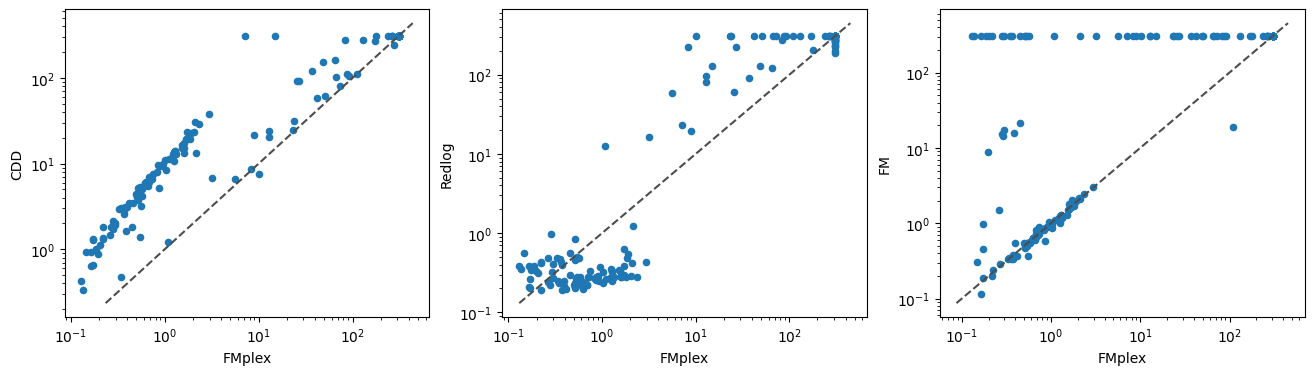

In [16]:
scatter_overview(df_nn, "runtime")

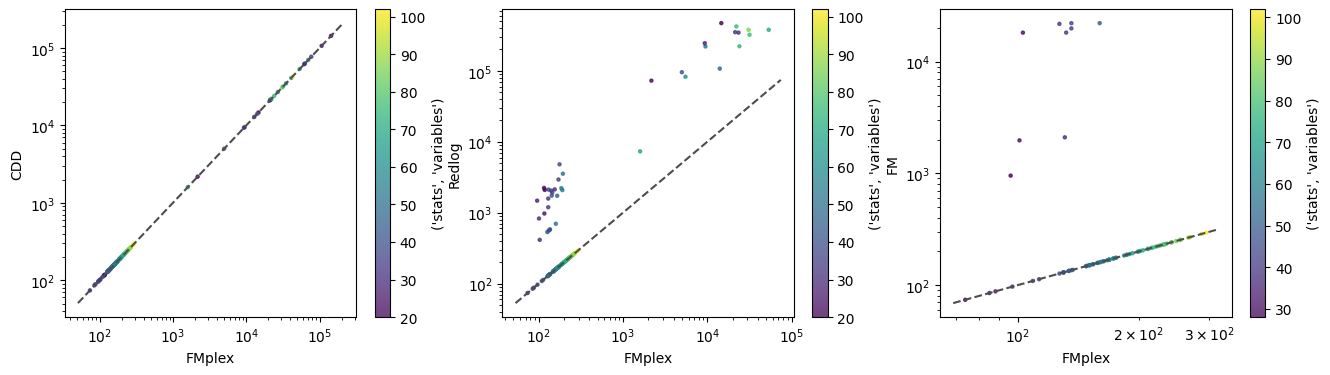

In [17]:
scatter_overview(df_nn, "output_constraints",
                 c=("stats", "variables"),
                 colormap="viridis",
                 alpha=0.75, s=5
                )
plt.show()

In [18]:
def fewer_constraints(s1, s2):
    return (lambda x: x[(s1,"answer")] == "success" and x[(s2,"answer")] == "success" and x[(s1,"output_constraints")] < x[(s2, "output_constraints")])

print(len(filter_rows(df_nn, fewer_constraints("CDD","FMplex"))))
print(len(filter_rows(df_nn, fewer_constraints("FM","FMplex"))))
print(len(filter_rows(df_nn, fewer_constraints("Redlog","FMplex"))))

0
0
0


In [19]:
print(len(df_nn[df_nn[("stats","variables")] >= 103])/270)
print(len(df_nn[df_nn[("stats","constraints")] >= 302])/270)
print(len(df_nn[df_nn[("stats","matrix-density-overall")] >= 0.36])/270)

0.0
0.0
0.0


## 3. SMT-Lib

In [20]:
df_smt = pd.read_csv("stats_smt_all.csv", header=[0,1], index_col=0)
summary(df_smt)

,FMplex,CDD,Redlog,FM
count,4798,4798,4798,4798
timeout,58,3491,253,0
memout,0,0,0,67
segfault,0,0,0,0
abort,0,0,0,0
invalid,0,1,0,0
success,4740,1306,4545,4731


In [21]:
invalids = df_smt[df_smt[("CDD","answer")] == "invalid"]
print(min(invalids[("CDD","peak_memory_kbytes")].values))

3991616


In [22]:
len(df_smt[df_smt[("Redlog","contains_disjunction")] == 1])

1934

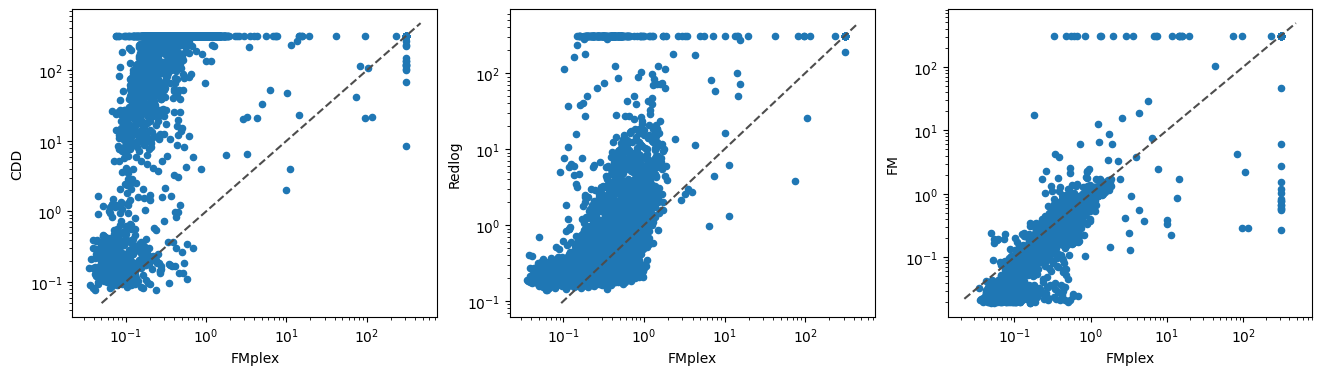

In [23]:
scatter_overview(df_smt, "runtime")

In [24]:
len(df_smt[df_smt[("stats","constraints")] > 99])/4798

0.9095456440183409

In [25]:
len(df_smt[df_smt[("stats","variables")] >= 50])/4798

0.8862025844101709

In [26]:
len(df_smt[df_smt[("stats","matrix-density-overall")] <= 0.05])/4798

0.8755731554814506

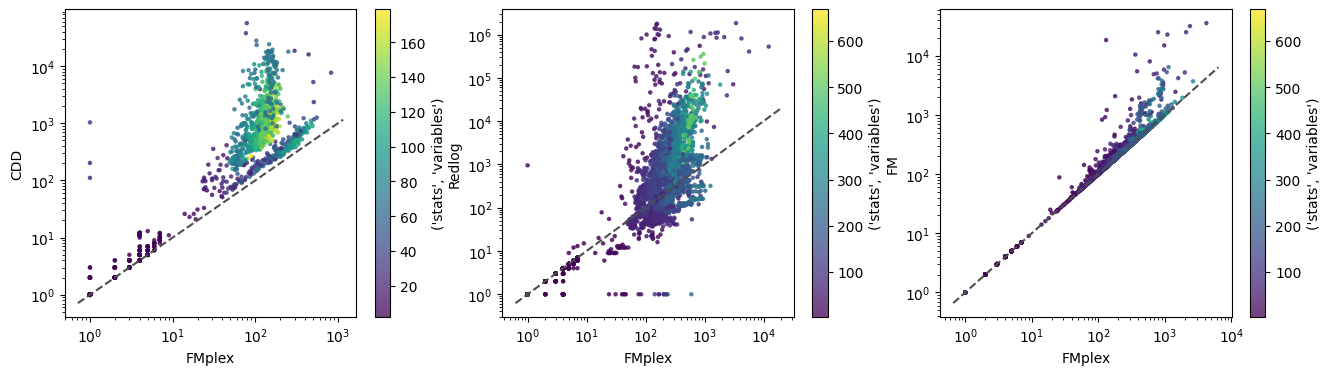

In [27]:
scatter_overview(df_smt, "output_constraints",
                 c=("stats", "variables"),
                 colormap="viridis",
                 alpha=0.75, s=5
                )
plt.show()

In [28]:
def fewer_constraints(s1, s2):
    return (lambda x: x[(s1,"answer")] == "success" and x[(s2,"answer")] == "success" and x[(s1,"output_constraints")] < x[(s2, "output_constraints")])

print(len(filter_rows(df_smt, fewer_constraints("CDD","FMplex"))))
print(len(filter_rows(df_smt, fewer_constraints("FM","FMplex"))))
print(len(filter_rows(df_smt, fewer_constraints("Redlog","FMplex"))))
print(len(filter_rows(df_smt, fewer_constraints("FMplex","Redlog"))))

0
0
2391
1841


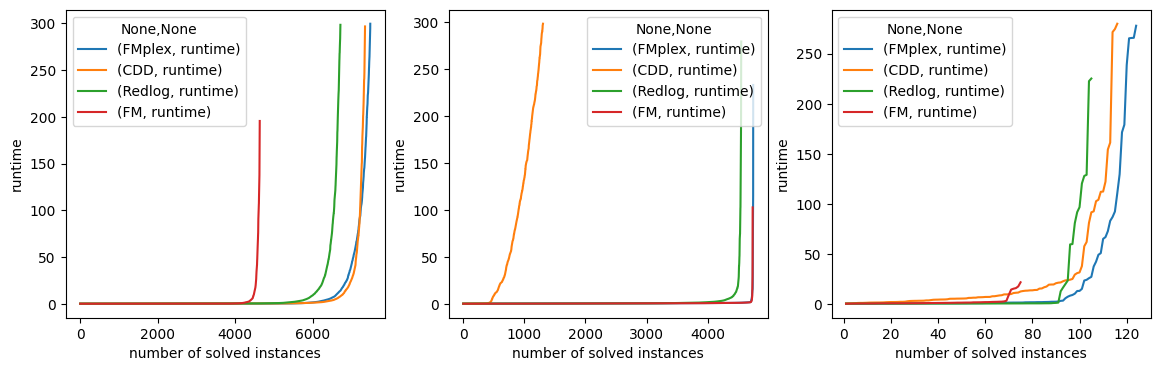

In [29]:
plt.figure(figsize=(14,4))
for i, df in enumerate([df_random, df_smt, df_nn]):#, df_smt, df_nn]):
    plt.subplot(1,3,i+1)

    ax = plt.gca()
    for solver in solvers:
        df_cum = df.loc[df[(solver,'answer')].isin(['success'])].copy()
        df_cum.loc[:,'num'] = 1
        df_cum = df_cum.groupby([(solver, 'runtime')]).count()
        df_cum.loc[:,'num'] = df_cum["num"].cumsum()
        df_cum = df_cum[['num']]
        df_cum = df_cum.reset_index().set_index('num')
        df_cum.plot.line(ax=ax)
    ax.set_ylabel('runtime')
    ax.set_xlabel("number of solved instances")
plt.show()